# Taxi Cab Trips Exploratory Data Analysis

In [225]:
import pandas as pd, seaborn as sns, numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [226]:
df = pd.read_csv("taxicab_prepped.csv")
df.head()

,VendorID,hour,rush_hour,day,month,passenger_count,trip_distance,ride_rate,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,subtotal,total_amount
0,2,8,0,saturday,march,6,3.34,3.892216,1,100,231,1,13.0,13.8,16.56
1,1,14,0,tuesday,april,1,1.80,8.888889,1,186,43,1,16.0,16.8,20.80
2,1,7,1,friday,december,1,1.00,6.500000,1,262,236,1,6.5,7.3,8.75
3,2,13,0,sunday,may,1,3.70,5.540541,1,188,97,1,20.5,21.3,27.69
4,2,23,0,saturday,april,1,4.37,3.775744,1,4,112,2,16.5,17.8,17.80


# Vendor ID

Now lets look at the vendor types, according to the data manual there are two vendor types and they correspond to the provider of the record or trip data. Let's look to see which provider has more or less expensive services

        1= Creative Mobile Technologies, LLC;

        2= VeriFone Inc.

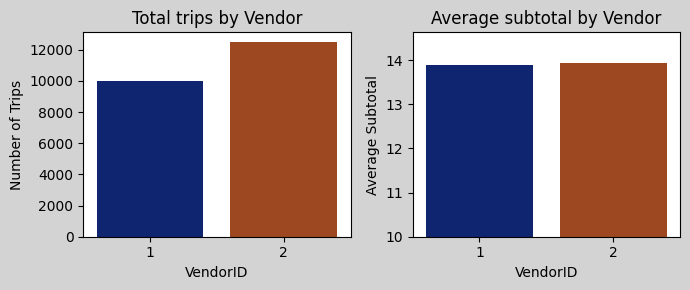

In [227]:
vendor_counts = df['VendorID'].value_counts()
vendor_costs = df.groupby('VendorID')['subtotal'].mean()

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
fig.patch.set_facecolor('lightgrey')

sns.barplot(x=vendor_counts.index, y=vendor_counts.values, palette='dark', hue = vendor_counts.index, legend = False, ax=axes[0])
axes[0].set_title('Total trips by Vendor')
axes[0].set_xlabel('VendorID')
axes[0].set_ylabel('Number of Trips')

sns.barplot(x=vendor_costs.index, y=vendor_costs.values, palette='dark', hue = vendor_costs.index, legend = False, ax=axes[1])
axes[1].set_title('Average subtotal by Vendor')
axes[1].set_xlabel('VendorID')
axes[1].set_ylabel('Average Subtotal')
axes[1].set_ylim(10)

plt.tight_layout()
plt.show()

There average cost of a trip (right) is nearly identicle (notice the lower limit on the chart is set to 10, so the tiny difference that is visble is only an illusion) no matter which vendor you happen to choose, however in the chart on the left it seems that Vendor 2 (Verifone) is chosen most often, this could be due to any number of reasons, some likely reasons being better ride quality, or the company has more units on the street so there is increased availablity.

# Hour & Rush Hour

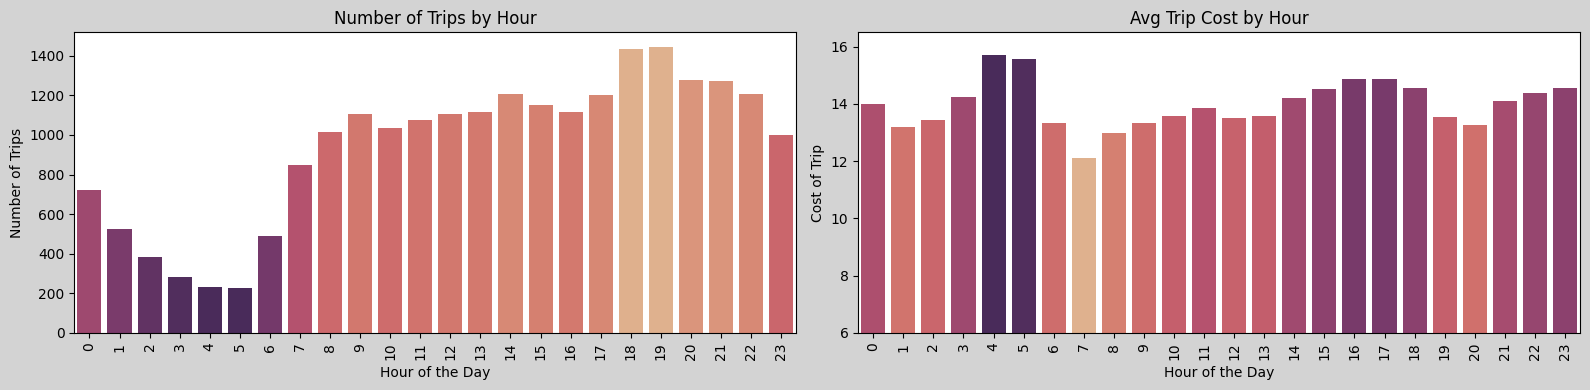

In [228]:
by_hour_counts = df["hour"].value_counts().sort_index()
by_hour_costs = df.groupby("hour")["subtotal"].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.patch.set_facecolor('lightgrey')

sns.barplot(x=by_hour_counts.index, y=by_hour_counts.values, palette='flare_r', hue = by_hour_counts.values, legend = False, ax=axes[0])
axes[0].set_title('Number of Trips by Hour')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Trips')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(x=by_hour_costs.index, y=by_hour_costs.values, palette='flare', hue = by_hour_costs.values, legend = False, ax=axes[1])
axes[1].set_title('Avg Trip Cost by Hour')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Cost of Trip')
axes[1].set_ylim(6)
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

From the chart on the left we can see unsurprisingly that the hours of midnight to 6am are the hours with the least volume of rides, and that the afternoon rush hour has the most volume. When we compare both charts we see that the avg trip cost varies unpredictably with the exception of 4 and 5am, which are the two hours with the least volume, so we can expect that some form of premium is charged during these hours, likely the overnight premium mentioned in the description of the "extra" column, but just to be sure let's check if longer rides are taken during these hours that would explain the variance in cost.

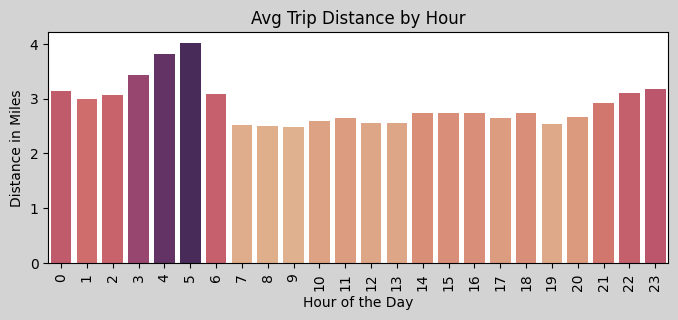

In [229]:
by_passenger_distance = df.groupby("hour")["trip_distance"].mean()

plt.figure(figsize=(8, 3))
plt.gcf().set_facecolor('lightgrey')

sns.barplot(x=by_passenger_distance.index, y=by_passenger_distance.values, palette='flare', hue = by_passenger_distance.values, legend = False)
plt.title('Avg Trip Distance by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Distance in Miles')
plt.xticks(rotation=90)

plt.show()

Surprisingly it seems that we have a solid correlation here, longer trips are more likely to be booked in the morning, which helps in explaining why trips around this time cost more on average.

Now let's look at rush hour, and see if it can tell us anything, but ffirst we will make a temporary dataframe that excludes Saturday and Sunday since these days do not include rush hour.

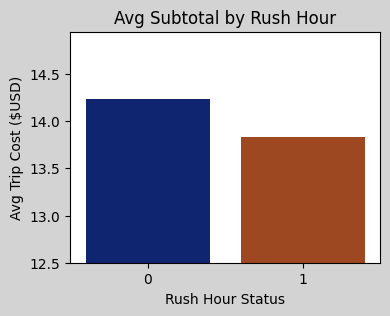

rush_hour
0    14.234199
1    13.835181
Name: subtotal, dtype: float64


In [230]:
# Seperate out the weekends so that a comparison can be made on rush_hour using only weekdays
df_no_weekends = df[(df["day"] != "saturday") & (df["day"] != "sunday")]

rush_hour_costs = df_no_weekends.groupby("rush_hour")["subtotal"].mean()

plt.figure(figsize=(4, 3))
plt.gcf().set_facecolor('lightgrey')
sns.barplot(x=rush_hour_costs.index, y=rush_hour_costs.values, palette="dark", hue = rush_hour_costs.index, legend= False)
plt.ylim(12.5)
plt.ylabel("Avg Trip Cost ($USD)")
plt.title("Avg Subtotal by Rush Hour")
plt.xlabel("Rush Hour Status")
plt.show()

print(rush_hour_costs)

It appears that the column for rush_hour holds no predictive power since the avg cost during rush hour is *less* than non-rush-hour hours.

**IN CONCLUSION...** with reguards to the hour feature, there is a clear and noticable spike in cost during the hours of 4-5am, and then price falls significantly and slowly rises thoughout the day, we could encode a binary variable for if a ride is being taken during the two hours of note, and remove the column rush_hour since it has proven irrelevant.

# Day & Month

Let's see do some quick analysis of these new variables and see if the final total of rides varies by the value of our new columns

In [231]:
day_order = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
month_order = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]


daily_counts = df["day"].value_counts().reindex(day_order)
daily_costs = df.groupby("day")["subtotal"].mean()
daily_costs = daily_costs.reindex(day_order)

monthly_counts = df["month"].value_counts().reindex(month_order)
monthly_costs = df.groupby("month")["subtotal"].mean()
monthly_costs = monthly_costs.reindex(month_order)

C:\Users\admin\AppData\Local\Temp\ipykernel_18772\2226037892.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
C:\Users\admin\AppData\Local\Temp\ipykernel_18772\2226037892.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
C:\Users\admin\AppData\Local\Temp\ipykernel_18772\2226037892.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
C:\Users\admin\AppData\Local\Temp\ipykernel_18772\2226037892.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[

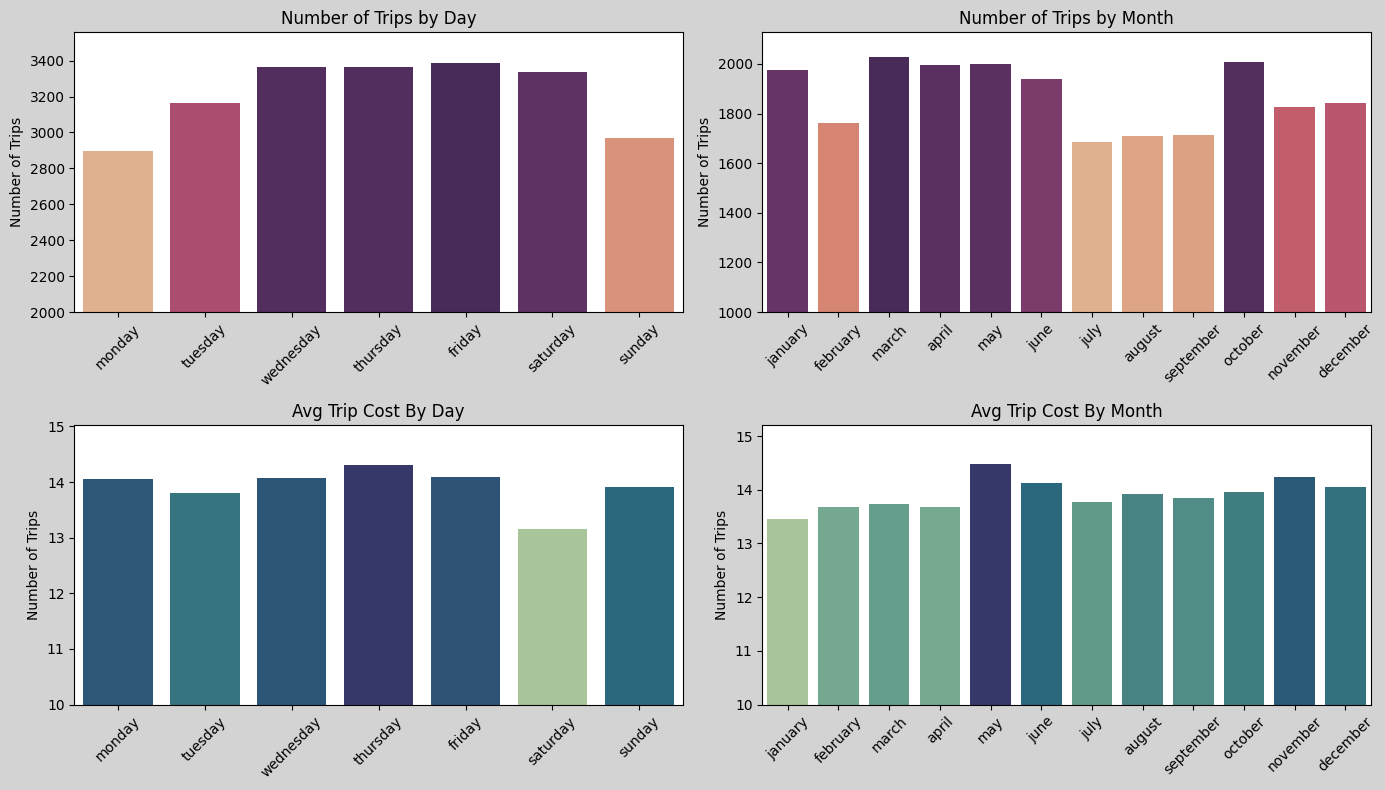

In [232]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.patch.set_facecolor('lightgrey')

sns.barplot(x=daily_counts.index, y=daily_counts.values, ax=axes[0,0], palette = "flare", hue = daily_counts.values, legend= False)
axes[0,0].set_title("Number of Trips by Day")
axes[0,0].set_xlabel('') 
axes[0,0].set_ylabel("Number of Trips")
axes[0,0].set_ylim(2000) 
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=axes[0,1], palette = "flare", hue = monthly_counts.values, legend= False)
axes[0,1].set_title("Number of Trips by Month")
axes[0,1].set_xlabel('') 
axes[0,1].set_ylabel("Number of Trips")
axes[0,1].set_ylim(1000) 
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

sns.barplot(x=daily_costs.index, y=daily_costs.values, ax=axes[1,0], palette = "crest", hue = daily_costs.values, legend= False)
axes[1,0].set_title("Avg Trip Cost By Day")
axes[1,0].set_xlabel('') 
axes[1,0].set_ylabel("Number of Trips")
axes[1,0].set_ylim(10) 
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)

sns.barplot(x=monthly_costs.index, y=monthly_costs.values, ax=axes[1,1], palette = "crest", hue = monthly_costs.values, legend= False)
axes[1,1].set_title("Avg Trip Cost By Month")
axes[1,1].set_xlabel('') 
axes[1,1].set_ylabel("Number of Trips")
axes[1,1].set_ylim(10) 
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Somewhat unsurprisingly there is not much variance in cost within the day and month columns, (ylimit on trip cost graphs is set to see the difference) besides saturday being a somewhat low day, where on average rides are 75 cents cheaper when averaged throughout the day. However due to the lack of significant effect these columns will not be in included in the final model.

# Passenger Count

Let's see if there is any change in total amount for different numbers of passengers.

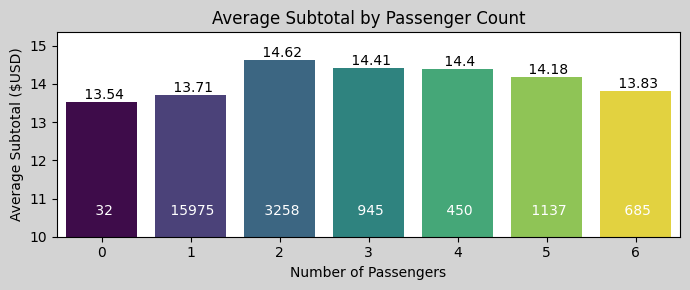

In [233]:
avg_total_amount = df.groupby("passenger_count")["subtotal"].mean()

plt.figure(figsize=(7, 3))
plt.gcf().set_facecolor('lightgrey')
sns.barplot(x=avg_total_amount.index, y=avg_total_amount.values, palette="viridis", hue = avg_total_amount.index, legend=False)
plt.xlabel('Number of Passengers')
plt.ylim(10)
plt.ylabel('Average Subtotal ($USD)')
plt.title('Average Subtotal by Passenger Count')

passenger_counts = df["passenger_count"].value_counts().sort_index()
for index, value in enumerate(avg_total_amount.values):
    count = passenger_counts.get(index, 0)
    plt.text(x=index, y=10.5, s=f' {count}', color='white', ha='center', va='bottom')
    plt.text(x=index, y=value, s=f' {round(value, 2)}', color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**[VALUE COUNTS SHOWN WITHIN BARS]**

We see no real discernable difference in the total amounts by different numbers of passengers (Note the Y-axes are regularized for a better display, and the differences in the data are much less percievable than they appear in the graphs above), if anything, cost peaks and decreases after 2 passengers. There are also trips with zero passengers, this could once again be an error in the dataset that needs investigation, however it's also noted that this only occurs 32 times, and could likely be an event such as a driver being paid to deliver a package for someone, and not actually transporting a rider. Inquiry with the drivers would be necessary for these 32 points, otherwise complete omission from the dataset could perhaps be wise.

Similar to what was done when exploring hour, let's see if the the cost trend within passenger_count can be explained by these combinations of counts taking longer or shorter rides.

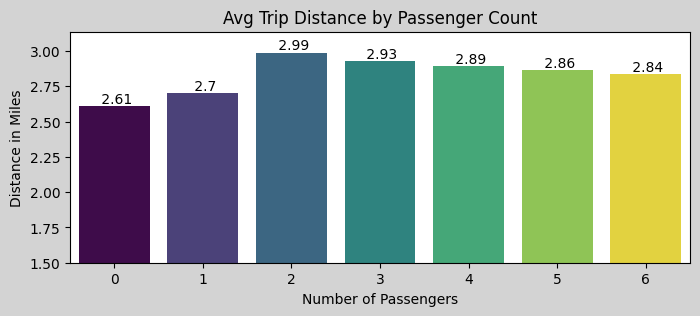

In [234]:
by_passenger_distance = df.groupby("passenger_count")["trip_distance"].mean()

plt.figure(figsize=(8, 3))
plt.gcf().set_facecolor('lightgrey')

sns.barplot(x=by_passenger_distance.index, y=by_passenger_distance.values, palette='viridis', hue = by_passenger_distance.index, legend = False)
plt.title('Avg Trip Distance by Passenger Count')
plt.xlabel('Number of Passengers')
plt.ylabel('Distance in Miles')
plt.ylim(1.5)

for index, value in enumerate(by_passenger_distance.values):
    plt.text(x=index, y=value, s=f' {round(value, 2)}', color='black', ha='center', va='bottom')

plt.show()

We see nearly the exact same distribution when we analyze the distance, meaning that all of the variance within passenger count is already being captured within trip distance and we don't expect passenger count to have any real predictive power in the final model.

# Trip Distance

Not only have we seen trip distance explain trends in some of the other features but we would also logically expect trip distance to be the most highly correlated variable with the subtotal since longer rides are going to cost more to complete, but let's visualize this relationship to be sure. But before we do that, we first have to seperate the tens of thousands of rows into a more usable format, so we'll split it into 11 new groups based off trip_distance, then find the mean subtotal for each group and plot a bar chart with these values.

In [235]:
bins = [0.0]
for i in range(1,11):
    bins.append(i/10)

quantiles = []
for i in bins:
    quantiles.append(df['trip_distance'].quantile(i))        
quantiles.sort()
print("Bin Edges:")
print(quantiles)

df['group'] = pd.cut(df['trip_distance'], bins=quantiles, include_lowest=True, right=True, duplicates='drop')
avg_ta_trip_dist = df.groupby('group', observed=False)['subtotal'].mean()

Bin Edges:
[0.0, 0.61, 0.87, 1.1, 1.31, 1.6, 2.0, 2.6, 3.6, 6.4, 20.11]


C:\Users\admin\AppData\Local\Temp\ipykernel_18772\1509453093.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(avg_ta_trip_dist_keys, rotation=45, ha="right")


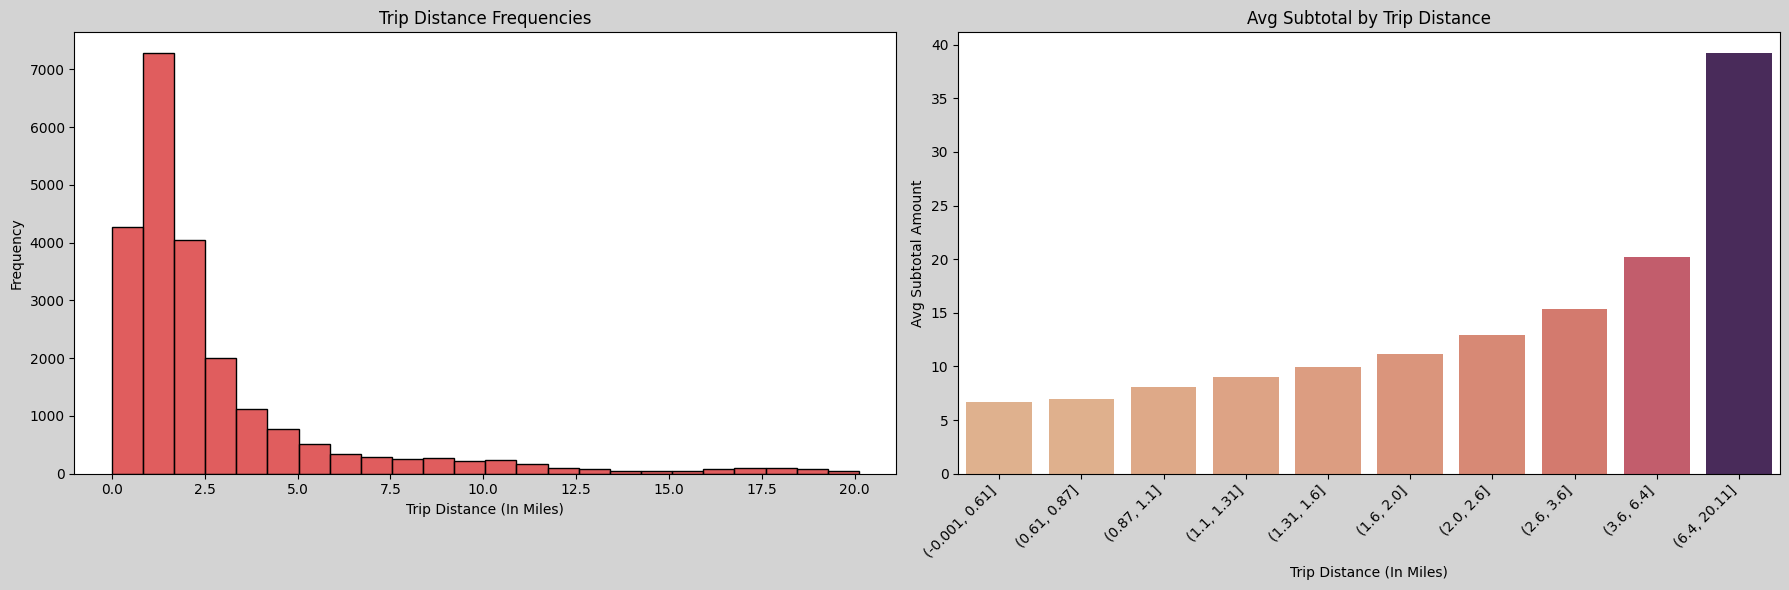

Mean of all trip_distances: 2.77 miles
Number of rides with distance of 0 miles: 135


In [236]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.patch.set_facecolor('lightgrey')

sns.histplot(df["trip_distance"], bins=24, color="tab:red", ax=axes[0])
axes[0].set_xlabel('Trip Distance (In Miles)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Trip Distance Frequencies')

avg_ta_trip_dist_keys = avg_ta_trip_dist.index.tolist()
avg_ta_trip_dist_values = avg_ta_trip_dist.values.tolist()
sns.barplot(x=avg_ta_trip_dist_keys, y=avg_ta_trip_dist_values, palette="flare", hue = avg_ta_trip_dist_values, legend = False, ax=axes[1])
axes[1].set_xticklabels(avg_ta_trip_dist_keys, rotation=45, ha="right")
axes[1].set_xlabel('Trip Distance (In Miles)')
axes[1].set_ylabel('Avg Subtotal Amount')
axes[1].set_title('Avg Subtotal by Trip Distance')

plt.tight_layout()
plt.show()

print(f'Mean of all trip_distances: {round(df["trip_distance"].mean(), 2)} miles')
print(f'Number of rides with distance of 0 miles: ' + str(sum(df['trip_distance']==0)))

Logically enough the trip_distances themselves are normally distributed around 2.77 miles (however right-skewed as well) meaning most riders book relatively short rides between 1-2.5 miles, but some riders book longer trips.

As expected we see a gradual increase in subtotal by trip_distance (it looks exponential only because there are trips with oulier distances as shown in the left hand graph) this relationship will be important to know later when we intend to predict the cost of a trip before it is taken, likely we will use machine learning to get as close to exact predictions on this relationship. It is also noted that there is a number of rides (135) that have a distance of 0, this could be due to any number of errors in the data entry however since the number of errors in this case (135 / 22000+) is relatively small. We will elect to not worry about thier effect on the final model that gets created.

# ::::: Try to explain spike in distance around 4/5 am

# Ratecode & Ride Rate

The data dictionary is somewhat unclear reguarding RatecodeID, first it does not specify what the different rates actually are, and second the dictionary says that this varible is only the ratecode in effect *"at the end of the trip"* suggesting that multiple ratecodes can be in effect any given trip, nonetheless, let's see if these ratecodes, correlate with the ride_rate feature we created, or in other words let's see if we can reverse engineer what these rates actually are, since they are never specified. Here are the ratecode definitions as a reminder.

        1= Standard rate

        2= JFK

        3= Newark

        4= Nassau or Westchester

        5= Negotiated fare

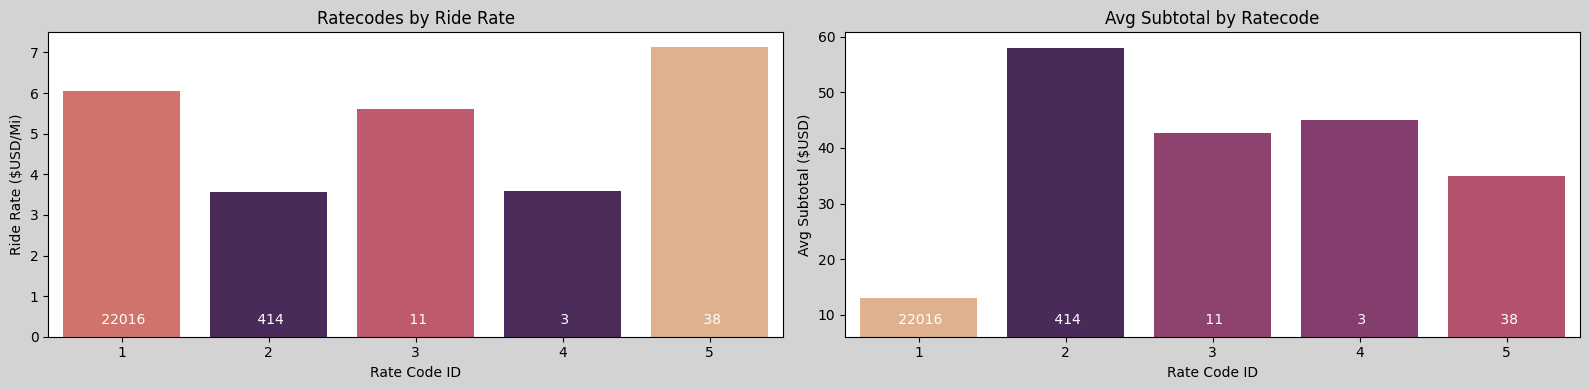

In [237]:
by_ratecode_counts = df["RatecodeID"].value_counts().sort_index(ascending=True)
by_ratecode_rates = df.groupby("RatecodeID")["ride_rate"].mean()
by_ratecode_costs = df.groupby("RatecodeID")["subtotal"].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.patch.set_facecolor('lightgrey')

sns.barplot(x=by_ratecode_rates.index, y=by_ratecode_rates.values, palette='flare_r', hue = by_ratecode_rates.values, legend = False, ax=axes[0])
axes[0].set_title('Ratecodes by Ride Rate')
axes[0].set_xlabel('Rate Code ID')
axes[0].set_ylabel('Ride Rate ($USD/Mi)')
for index, value in enumerate(by_ratecode_counts.values):
    axes[0].text(x=index, y=0.4, s=f' {round(value, 2)}', color='white', ha='center', va='center')

sns.barplot(x=by_ratecode_costs.index, y=by_ratecode_costs.values, palette='flare', hue = by_ratecode_costs.values, legend = False, ax=axes[1])
axes[1].set_title('Avg Subtotal by Ratecode')
axes[1].set_xlabel('Rate Code ID')
axes[1].set_ylabel('Avg Subtotal ($USD)')
axes[1].set_ylim(6)
for index, value in enumerate(by_ratecode_counts.values):
    axes[1].text(x=index, y=9, s=f' {round(value, 2)}', color='white', ha='center', va='center')

plt.tight_layout()
plt.show()

**[NUMBER OF TRIPS BY RATECODE SHOW WITHIN BARS]**

What we see here is rather interesting, in the Ride Rate chart (left) we see that the standard rate is about 6 dollars and the JFK (airport) rate is only around 3.5 dollars. However in the subtotal chart (right) we see that the avg subtotal cost for a trip to JFK is nearly 60 dollars! Let's print out some rows of the data frame with the JFK ratecode and see what is causing this high average.

exlplore ratecode 1&2 more in depth the rate for #2 is less but the subtotal is more?

In [241]:
df[df["RatecodeID"] == 2].head(10)

,VendorID,hour,rush_hour,day,month,passenger_count,trip_distance,ride_rate,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,subtotal,total_amount,group
11,2,19,0,sunday,march,2,18.90,2.751323,2,236,132,1,52.0,58.34,72.92,"(6.4, 20.11]"
108,1,14,0,saturday,june,1,18.00,2.888889,2,132,163,1,52.0,52.80,52.80,"(6.4, 20.11]"
159,2,20,0,saturday,november,1,0.23,7.138961,2,132,132,2,52.0,52.80,52.80,"(-0.001, 0.61]"
243,2,23,0,wednesday,december,1,18.93,2.746962,2,132,79,2,52.0,52.80,52.80,"(6.4, 20.11]"
373,2,23,0,sunday,september,1,17.99,2.890495,2,132,234,1,52.0,58.56,73.20,"(6.4, 20.11]"
382,1,18,1,tuesday,february,1,18.40,2.826087,2,132,48,2,52.0,62.84,62.84,"(6.4, 20.11]"
400,2,12,0,monday,june,1,4.73,10.993658,2,228,88,2,52.0,58.56,58.56,"(3.6, 6.4]"
442,2,22,0,thursday,august,2,18.21,2.855574,2,132,48,2,52.0,58.56,58.56,"(6.4, 20.11]"
461,2,13,0,tuesday,september,1,17.27,3.011002,2,186,132,2,52.0,58.56,58.56,"(6.4, 20.11]"
513,2,21,0,sunday,april,6,18.34,2.835333,2,132,148,1,52.0,52.80,57.80,"(6.4, 20.11]"


All of the values for fare_amount are 52.00 exactly, perhaps the JFK ratecode is a flat charge of $52.00, let's verify if this is true with a call to the value counts of the JFK rows.

In [240]:
df[df["RatecodeID"] == 2]["fare_amount"].value_counts()

fare_amount
52.0    414
Name: count, dtype: int64

It is indeed the case that a trip to JFK airport is a flat fee of $52.00, no matter how close or far you are away from the airport, which explains the discrepancy between our two graphs. Though this is beside the point for the goal of our analysis, we can see that drivers make significantly less dollars per mile on average by taking people to JFK airport, perhaps this is some sort of unique-value-proposition offered by the company and enforced on the drivers. Perhaps it is used a method of "getting customers in the door" if you will, by gaining the confidence and affinity of customers when they need to take a taxi to go to the airport maybe they will be more likely to book a taxi even when they aren't going to JFK. Because we know trips to JFK will always be $52.00, the values for this rate code can be imputed back into the data after the model makes its predictions. This way you know that those data points will always be correct.

# Pickup & Dropoff Location

These two features are somewhat tricky to deal with, there is a large amount of locations for both. So we'll have to be clever to make use of thse columns. 

find locations with most deviance from the average for both variables and see what can be gleaned (scatter plots to visualize the entirety of the data)

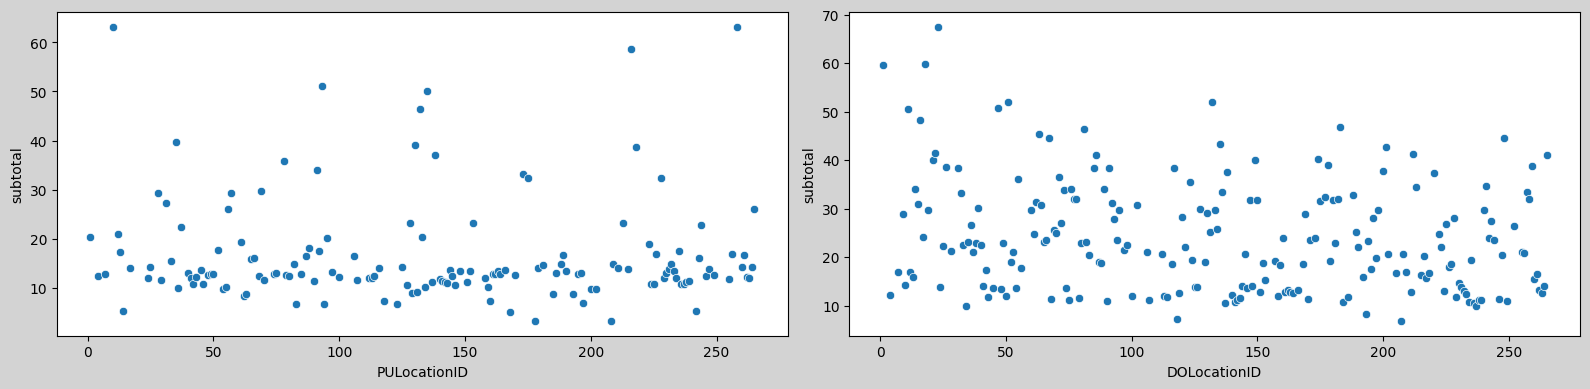

In [264]:
pickup_costs = df.groupby("PULocationID")["subtotal"].mean()
dropoff_counts = df.groupby("DOLocationID")["subtotal"].mean()
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.patch.set_facecolor('lightgrey')

sns.scatterplot(pickup_costs, ax = axes[0])

sns.scatterplot(dropoff_counts, ax = axes[1])

plt.tight_layout()
plt.show()

Unsurprsingly there is not much use for the data in this form, there is simply too many different locations that taxis go to in NYC. We could try to make a new link between certain pickup and dropoff locations and see if they have a common price, but since there an average of about two hundred locations in each, we could end up with 200! diffent "trip_codes" if you will. and even if they had similar prices within the groups, it would be extremely tedious to encode them all into a dataframe for a model to use. So we will ignore these two columns as they are too complex without providing enough value for our purposes.

# Payment Type

There are 6 payment types, let's see if we can see any notable effect on subtotal by these different types.

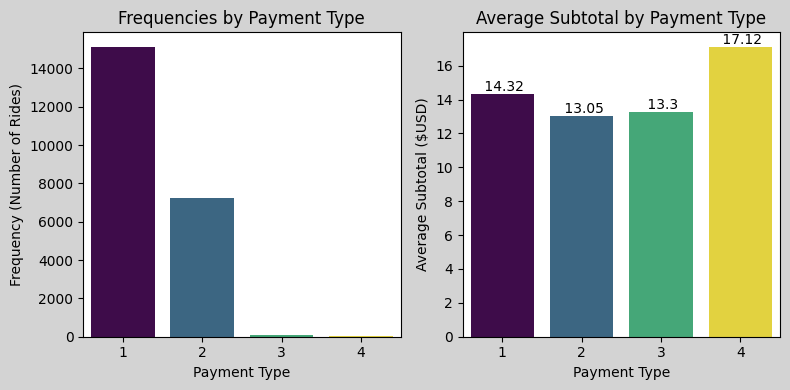

In [265]:
payment_type_counts = df["payment_type"].value_counts().sort_index()
payment_type_costs = df.groupby("payment_type")["subtotal"].mean().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.patch.set_facecolor("lightgrey")

sns.barplot(ax=axes[0], x=payment_type_counts.index, y=payment_type_counts.values, palette="viridis", hue = payment_type_counts.index, legend = False)
axes[0].set_title('Frequencies by Payment Type')
axes[0].set_xlabel('Payment Type')
axes[0].set_ylabel('Frequency (Number of Rides)')

sns.barplot(ax=axes[1], x=payment_type_costs.index, y=payment_type_costs.values, palette="viridis", hue = payment_type_costs.index, legend = False)
axes[1].set_title('Average Subtotal by Payment Type')
axes[1].set_xlabel('Payment Type')
axes[1].set_ylabel('Average Subtotal ($USD)')
for index, value in enumerate(payment_type_costs.values):
    axes[1].text(x=index, y=value, s=f' {round(value, 2)}', color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()

It seems "Credit Card" is by far the most popular, followed by "Cash", and then followed by "No Charge" and "Dispute" with reltatively little frequency. It's noted that there are two more types 5 and 6, "Uknown" and "Voided Trip" respectively, that never occur in this dataset. When looking at the average subtotal by the payment method, we can see that there is a difference of about a $1.30 between cash and card, let's investigate this difference. First let's look at the difference by fare_amount rather than by subtotal, to verify if the differences are not due to the various extra charges such as tax that get tacked on to the fare amount.

In [ ]:
df.groupby("payment_type")["fare_amount"].mean()[:2]

payment_type
1    12.873277
2    11.754680
Name: fare_amount, dtype: float64

It seems that those that pay with credit card still end up paying roughly $1.10 more on their fares. Let's conduct a hypothesis test to see if this is a statitsically relevant insight.

For our h-test we will use a two sample t-test and a significance level of 5% or 0.05. And our hypotheses will be:

H_o will be that there is no difference in the average fare amount by payment type.

H_a will be that there is a difference in the average fare amount by payment type.

In [ ]:
card = df[df["payment_type"] == 1]
cash = df[df["payment_type"] == 2]

stats.ttest_ind(a = card["fare_amount"], b = cash["fare_amount"], equal_var=False)

TtestResult(statistic=8.230839901571619, pvalue=2.011819627601259e-16, df=14910.452062358117)

The resulting p-value is very small; meaning that we can reject the null hypothesis and must accept that there is a significant difference in the average fare_amount charged to those paying by credit cards versus those paying by cash, suggesting that it would be wise to encode a binary variable in the final model to capture this information. However, just because the variable itself is significant, it doesn't mean its variance cannot be captured by another variable, it's possible that as prices go higher people are naturally more inclined to pay by credit card. Let's compare payment type to distance to see if there is any merit to this assumption.

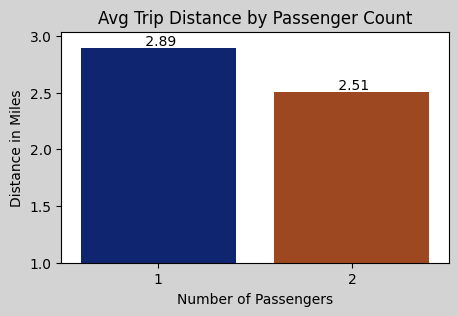

In [ ]:
payment_type_distance = df.groupby("payment_type")["trip_distance"].mean()[:2]

plt.figure(figsize=(5, 3))
plt.gcf().set_facecolor('lightgrey')

sns.barplot(x=payment_type_distance.index, y=payment_type_distance.values, palette='dark', hue = payment_type_distance.index, legend = False)
plt.title('Avg Trip Distance by Passenger Count')
plt.xlabel('Number of Passengers')
plt.ylabel('Distance in Miles')
plt.ylim(1)

for index, value in enumerate(payment_type_distance.values):
    plt.text(x=index, y=value, s=f' {round(value, 2)}', color='black', ha='center', va='bottom')

plt.show()

Note: Types 3 and 4 were omitted from this graph due to small sample size likely causing inaccurate or unreflective data

If we take the ratio of these values and compare them to the ratio of the values from the Subtotal chart we will get (13.05 / 14.32 = 0.91, and 2.51 / 2.89 = 0.86) 0.91 and 0.86 between cash and card respectively, nearly the same ratio for both meaning the the difference we see in subtotal is likely causation by the increased trip distance and people choosing to pay by card more often for long trips, either because they don't have cash on them or because it's more convenient

# ADD SECTION PROVING ASSUMPTIONS FOR LIN_REG

In [ ]:
df.head()

,VendorID,hour,rush_hour,day,month,passenger_count,trip_distance,ride_rate,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,subtotal,total_amount,group
0,2,8,0,saturday,march,6,3.34,3.892216,1,100,231,1,13.0,13.8,16.56,"(2.6, 3.6]"
1,1,14,0,tuesday,april,1,1.80,8.888889,1,186,43,1,16.0,16.8,20.80,"(1.6, 2.0]"
2,1,7,1,friday,december,1,1.00,6.500000,1,262,236,1,6.5,7.3,8.75,"(0.87, 1.1]"
3,2,13,0,sunday,may,1,3.70,5.540541,1,188,97,1,20.5,21.3,27.69,"(3.6, 6.4]"
4,2,23,0,saturday,april,1,4.37,3.775744,1,4,112,2,16.5,17.8,17.80,"(3.6, 6.4]"


In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap',
          fontsize=18)
plt.show()